# Speech-based Emotion Recognition for Voice Comms.
## Main Notebook

Datasets used:

*   RAVDESS, Emo-DB, SAVEE, TESS
*   See AugmentData.ipynb for augmentation scripts    

In [50]:
import soundfile # read audio files
import numpy as np
import librosa # extract features
import glob
import os
import pickle # to save model after training

from sklearn.model_selection import train_test_split # for splitting training and testing data
from sklearn.neural_network import MLPClassifier # multi-layer perceptron model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix # generate cm

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [51]:
def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32") # all depth 32bit float
        sample_rate = sound_file.samplerate # should always be 16kHz
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result

In [52]:
# all emotions RAVDESS
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# all emotions emoDB
char2emotion = {
    "N": "neutral",
    "F": "happy",
    "T": "sad",
    "W": "angry",
    "A": "fearful",
    "E": "disgust",
    "L": "boredom",
}

# all emotions SAVEE
saveeemotion = {
    "n": "neutral",
    "h": "happy",
    "s": "sad",
    "a": "angry",
    "f": "fearful",
    "d": "disgust",
    "p": "surprised",
}

# all emotions TESS
tessemotion = {
    "neutral.wav": "neutral",
    "happy.wav": "happy",
    "sad.wav": "sad",
    "angry.wav": "angry",
    "fear.wav": "fearful",
    "disgust.wav": "disgust",
    "ps.wav": "surprised",
}

# allow only these emotions from dataset(s)
AVAILABLE_EMOTIONS = {
    "neutral",
    #"calm", only included in RAVDESS
    "happy",
    "sad",
    "angry", # 1
    "fearful",
    "disgust", # 2
    #"surprised" not included in emodb
}

# load data and extract features
def load_data(test_size=0.2):
    X, y = [], []
    
    # RAVDESS clean
    for file in glob.glob("data/RAVDESS-nosil/*.wav"):
        # get the base name of the audio file
        basename = os.path.basename(file)
        # get the emotion label
        emotion = int2emotion[basename.split("-")[2]]
        # we allow only AVAILABLE_EMOTIONS we set
        if emotion not in AVAILABLE_EMOTIONS:
            continue
        # extract features
        features = extract_feature(file, mfcc=True)
        # add to data
        X.append(features)
        y.append(emotion)
    
#     # augmented RAVDESS
#     # white noise
#     for file in glob.glob("data/augment-wn/RAVDESS/*.wav"):
#         # get the base name of the audio file
#         basename = os.path.basename(file)
#         # get the emotion label
#         emotion = int2emotion[basename.split("-")[2]]
#         # we allow only AVAILABLE_EMOTIONS we set
#         if emotion not in AVAILABLE_EMOTIONS:
#             continue
#         # extract features
#         features = extract_feature(file, mfcc=True)
#         # add to data
#         X.append(features)
#         y.append(emotion)
    
#     # emodb    
#     for file in glob.glob("data/emodb/*.wav"):
#         # get the base name of the audio file
#         basename = os.path.basename(file)
#         # get the emotion label
#         emotion = char2emotion[basename[5]]
#         # we allow only AVAILABLE_EMOTIONS we set
#         if emotion not in AVAILABLE_EMOTIONS:
#             continue
#         # extract features
#         features = extract_feature(file, mfcc=True)
#         # add to data
#         X.append(features)
#         y.append(emotion)
    
#     # SAVEE
#     for file in glob.glob("data/SAVEE/*/*.wav"):
#         # get the base name of the audio file
#         basename = os.path.basename(file)
#         # get the emotion label
#         emotion = saveeemotion[basename[0]]
#         # we allow only AVAILABLE_EMOTIONS we set
#         if emotion not in AVAILABLE_EMOTIONS:
#             continue
#         # extract features
#         features = extract_feature(file, mfcc=True)
#         # add to data
#         X.append(features)
#         y.append(emotion)
    
#     # TESS
#     for file in glob.glob("data/tess/*/*.wav"):
#         # get the base name of the audio file
#         basename = os.path.basename(file)
#         # get the emotion label
#         emotion = tessemotion[basename.split("_")[2]]
#         # we allow only AVAILABLE_EMOTIONS we set
#         if emotion not in AVAILABLE_EMOTIONS:
#             continue
#         # extract features
#         features = extract_feature(file, mfcc=True)
#         # add to data
#         X.append(features)
#         y.append(emotion)
    
    # split the data to training and testing and return it
    return train_test_split(np.array(X), y, test_size=test_size, random_state=420)

In [53]:
# load dataset(s), 75% training 25% testing
X_train, X_test, y_train, y_test = load_data(test_size=0.25)

In [54]:
# print some details
# number of samples in training data
print("[+] Number of training samples:", X_train.shape[0])
# number of samples in testing data
print("[+] Number of testing samples:", X_test.shape[0])
# number of features used
# vector of features extracted 
# using extract_features() function
print("[+] Number of features:", X_train.shape[1])

[+] Number of training samples: 792
[+] Number of testing samples: 264
[+] Number of features: 40


In [55]:
# best model params, determined by a grid search run by tutorial author, to be updated
model_params = {
    'alpha': 0.01,
    'batch_size': 256,
    'epsilon': 1e-08, 
    'hidden_layer_sizes': (300,), 
    'learning_rate': 'adaptive', 
    'max_iter': 500, 
}

In [56]:
# initialize Multi Layer Perceptron classifier
# with best parameters (so far)
# RESET MODEL?
model = MLPClassifier(**model_params)

In [57]:
# train the model
print("[*] Training the model...")
model.fit(X_train, y_train)

[*] Training the model...


MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=500, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

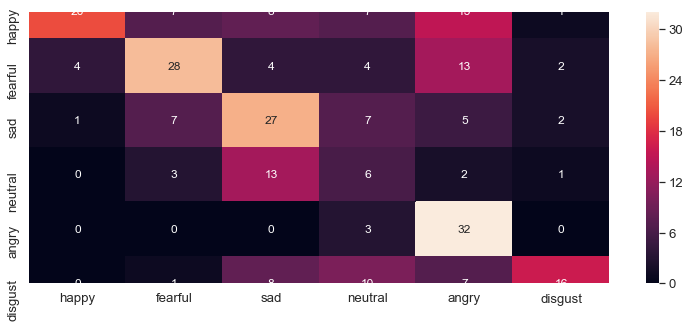

Accuracy: 48.86%


In [58]:
# predict 25% of our data
y_pred = model.predict(X_test)

# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=list(AVAILABLE_EMOTIONS))
x_axis_labels = y_axis_labels = AVAILABLE_EMOTIONS

# plot cm dataframe
df_cm = pd.DataFrame(cm, range(6), range(6))
plt.figure(figsize=(13,5))
sn.set(font_scale=1.2) # for labels
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.show()

# calculate the accuracy
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

In [18]:
# save the model
# make result directory if doesn't exist yet
if not os.path.isdir("result"):
    os.mkdir("result")

pickle.dump(model, open("result/mlp_classifier.model", "wb"))